In [1]:
import numpy as np, sympy as sp, control as ct
import matplotlib.pyplot as plt
from functools import reduce

### PID controller$$G_c(s)=K_p\left[1+\frac{1}{sT_i}+sT_d\right]$$

### 2-DOF PID

![title](img/2dof_control.png)

1. Design $G_C(s) = G_{C1}(s)G_{C2}(s) = K\frac{(s+\alpha)(s+\beta)}{s}$ so as to satisfy disturbance specifications
2. Write output to disturbance transfer function $$\frac{Y}{D} = \frac{G_p}{1+(G_{C1}G_{C2})G_P} = \frac{G_p}{1+G_CG_P}$$
3. Get overshoot and settling time for the desired response $$M_p = e^{-\pi\xi/\sqrt{1-\xi^2}}\qquad t_s = \frac{4}{\xi\omega_n}$$
4. Write the desired characteristic equation using the obtained values, this should have the same order as $1+G_CG_P$ $$(s^2+2\xi\omega_ns+\omega_n^2)(s+p_3)(s+p_4)\ldots(s+p_n)$$
5. Find $K$, $\alpha$ and $\beta$ setting $1+G_CG_P = \text{desired characteristic equation}$
6. Use the fact that $\frac{Y}{R} = G_{C1}\frac{Y}{D}$ to place the zeros of the transfer function and find $G_{C1}$. If the numerator of $\frac{Y}{R}$ is equal to the last 3 terms of the denominator of $\frac{Y}{D}$, then it's given that there is no steady state error for step, ramp and parabola inputs
7. Since $G_C$ and $G_{C1}$ are determined we can find $G_{C2}$ $$G_{C2} = G_C-G_{C1}$$

In [2]:
def two_dof_pid(*, sys: ct.TransferFunction, csi: float=None, ts: float=None, pole: float|complex=None, overshoot: float=None) -> tuple[ct.TransferFunction, ct.TransferFunction]:
    if csi != None and ts != None:
        omega_n = 4/(ts*csi)
        omega_d = omega_n * np.sqrt(1-csi**2)
        p1 = -csi*omega_n + 1j*omega_d
        p2 = -csi*omega_n - 1j*omega_d
    elif pole != None:
        p1 = pole
        p2 = p1.real - p1.imag
    elif overshoot != None and ts != None:
        csi = -np.log(overshoot)/np.sqrt(np.pi**2+np.log(overshoot)**2)
        omega_n = 4/(ts*csi)
        omega_d = omega_n * np.sqrt(1-csi**2)
        p1 = -csi*omega_n + 1j*omega_d
        p2 = -csi*omega_n - 1j*omega_d
    else:
        raise Exception(ValueError)
    
    # Define symbols and convert TransferFunction object into sympy expression
    s, alpha, beta, K, gc1 = sp.symbols("s alpha beta K G_{C1}")
    gp_num = sys.num[0][0]
    gp_den = sys.den[0][0]
    gp = sp.Poly(gp_num, s)/sp.Poly(gp_den, s)

    # Define closed loop poles
    poles = (s-p1)*(s-p2)
    
    # (nom dominant poles are allocated at 5*i*Re{p1} so as to not impact response too much)
    for i in range(1, len(gp_den)-1):
        pi = 5*i*p1.real
        poles = poles*(s-pi)
    poles = poles.expand()

    gc = K*(s+alpha)*(s+beta)/s

    # Create Output/Disturbance transfer function
    y_d = (gp/(1+gp*gc)).simplify()
    den = sp.collect(sp.denom(y_d).expand(), s)

    # Equate desired characteristic equation coefficients and solve for K, alpha and beta
    eqs = []
    for t1, t2 in zip(sorted(den.args, key=lambda x: sp.degree(x, s)), sorted(poles.args, key=lambda x: sp.degree(x, s))):
        eqs.append(sp.Eq(t1, t2))
    
    sol = sp.solve(eqs, (K, alpha, beta))[0]

    # Substitute found values
    gc_solved = gc.subs({K:sol[0], alpha:sol[1], beta:sol[2]})
    y_d_solved = y_d.subs({K:sol[0], alpha:sol[1], beta:sol[2]})

    # Create Output/Reference transfer function -> Y/R = G_C1*Y/D
    y_r = (gc1*y_d_solved).expand()

    # Numerator of Y/R must be equal to last three terms of denominator to eliminate steady state error for step, ramp and parabola
    num_target = reduce(lambda acc, curr: acc+curr, (term for term in sp.denom(y_r).args if sp.degree(term) < 3), 0)
    curr_num = sp.numer(y_r)

    # Solve for G_C1
    gc1_solved = sp.solve(sp.Eq(curr_num, num_target), gc1)[0].factor()

    # Solve for G_C2
    gc2_solved = (gc_solved - gc1_solved).simplify()

    # Convert sympy expressions back into control TransferFunction objects
    gc1_num = [float(a) for a in sp.Poly(sp.numer(gc1_solved), s).all_coeffs()]
    gc1_den = [float(a) for a in sp.Poly(sp.denom(gc1_solved), s).all_coeffs()]
    gc1_tf = ct.tf(gc1_num, gc1_den)

    gc2_num = [float(a) for a in sp.Poly(sp.numer(gc2_solved), s).all_coeffs()]
    gc2_den = [float(a) for a in sp.Poly(sp.denom(gc2_solved), s).all_coeffs()]
    gc2_tf = ct.tf(gc2_num, gc2_den)

    return gc1_tf, gc2_tf

In [3]:
gp = ct.tf(10, [1, 1, 0])
gc1, gc2 = two_dof_pid(sys=gp, overshoot=0.1, ts=1)

In [4]:
y_d = gp/(1+(gc1+gc2)*gp)
y_r = gc1*y_d

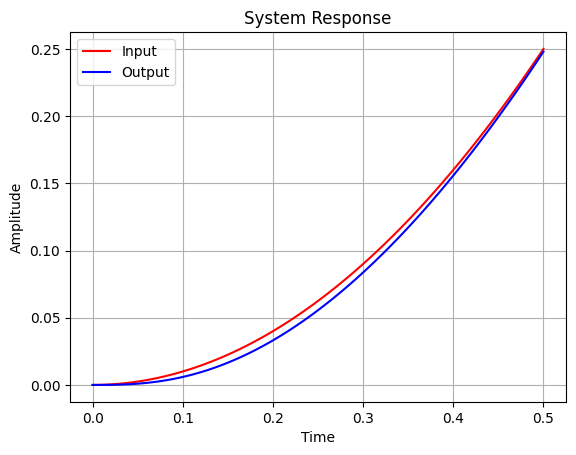

In [5]:
t = np.linspace(0, 0.5, 100)

a_t = t**2

t_out, y_out = ct.forced_response(y_r, T=t, U=a_t)

plt.plot(t, a_t, label='Input', c="r")
plt.plot(t_out, y_out, label='Output', c="b")
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('System Response')
plt.legend()
plt.grid(True)
plt.show()

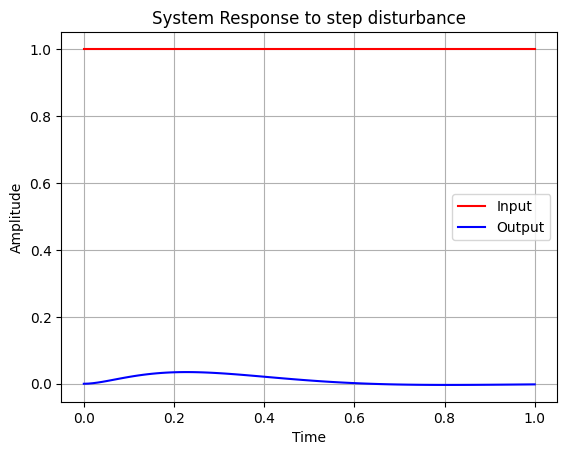

In [6]:
t = np.linspace(0, 1, 100)

a_t = np.ones(t.shape)

t_out, y_out = ct.forced_response(y_d, T=t, U=a_t)

plt.plot(t, a_t, label='Input', c="r")
plt.plot(t_out, y_out, label='Output', c="b")
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('System Response to step disturbance')
plt.legend()
plt.grid(True)
plt.show()